Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [69]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Test')

In [70]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
## test ds
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  #validation_split = 0.2,
  #subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# Keras.preprocessing
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#BATCH_SIZE = 32
#IMG_HEIGHT = 180 # This should map with the height and width of the pretrained model
#IMG_WIDTH = 180 # This should map with the height and width of the pretrained model
STEPS_PER_EPOCH = np.ceil(image_count_train/batch_size)

train_data_gen = image_generator.flow_from_directory(directory=data_dir_train,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(img_height, img_width),
                                                     classes = class_names)


Found 2239 images belonging to 9 classes.


In [13]:
class_names_ndarray = np.array([item.name for item in data_dir_train.glob('*')])
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,10))
  x=0
  class_names_temp=class_names.copy()
  print('len of class_name_temp:',len(class_names_temp))
  # print(class_names_temp)
  for n in range(32):
    # print('n:',n)
    title=class_names_ndarray[label_batch[n]==1][0].title()
    # print('title:',title)
    if title.lower() in class_names_temp:
      # print('x:',x)
      ax = plt.subplot(2,5,x+1)
      # print(type(title))
      plt.imshow(image_batch[n])
      plt.title(class_names_ndarray[label_batch[n]==1][0].title())
      x=x+1
      class_names_temp.remove(title.lower())
      plt.axis('off')

len of class_name_temp: 9


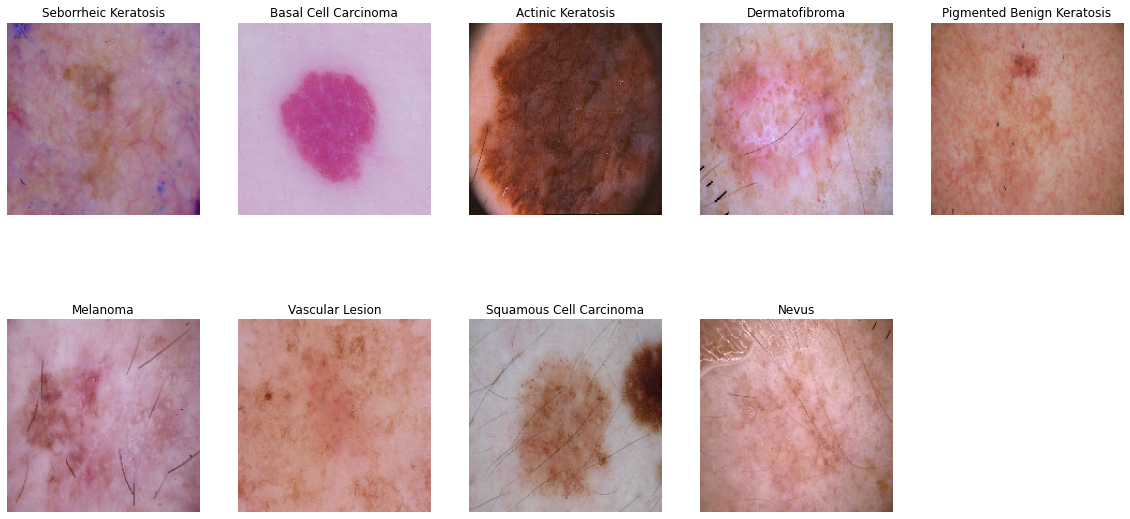

In [15]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [148]:
print(train_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


### Create model 1 (Base Model)
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [125]:
# define Base model
def define_cnn_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPool2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPool2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(9, activation='softmax'))
 
 return model

In [126]:
model1=define_cnn_model()

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [127]:
### Todo, choose an appropirate optimiser and loss function
# compile model
from keras.optimizers import SGD
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [128]:
# View the summary of all layers
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 180, 180, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 90, 90, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 129600)           

### Train the model

In [129]:
epochs = 20
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
    )

Epoch 1/20
56/56 [==============================] - 24s 157ms/step - loss: 1687.0714 - accuracy: 0.2205 - val_loss: 2.1163 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 4s 66ms/step - loss: 1.8371 - accuracy: 0.3583 - val_loss: 1.7817 - val_accuracy: 0.3557
Epoch 3/20
56/56 [==============================] - 4s 67ms/step - loss: 1.7024 - accuracy: 0.3822 - val_loss: 1.7633 - val_accuracy: 0.3960
Epoch 4/20
56/56 [==============================] - 4s 67ms/step - loss: 1.6756 - accuracy: 0.4381 - val_loss: 1.7449 - val_accuracy: 0.3893
Epoch 5/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5562 - accuracy: 0.4450 - val_loss: 1.8292 - val_accuracy: 0.3512
Epoch 6/20
56/56 [==============================] - 4s 68ms/step - loss: 1.4997 - accuracy: 0.4750 - val_loss: 1.8421 - val_accuracy: 0.4027
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4936 - accuracy: 0.4683 - val_loss: 1.9038 - val_accuracy: 0.3937
Epoch 8/

### Visualizing training results

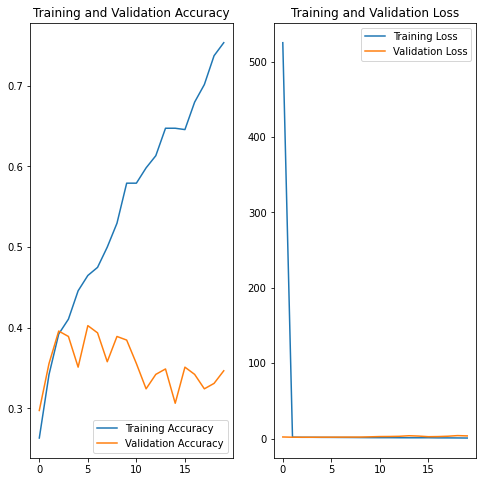

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [131]:
#Test Prediction error
### Test the model
history_test = model1.evaluate(
  test_ds
)
history_test

4/4 [==============================] - 46s 200ms/step - loss: 7.9055 - accuracy: 0.2288


[7.9054999351501465, 0.2288135588169098]

#### Findings of Model 1:


*   Huge deviation between Training and Validation Accuracy, hence its clear indication of Overfitting
*   Test Accuracy ranges around 22%, there is lots of space for model improvement
*   Training and Validation Loss function fluctuates widely






### Model 2 development: ( Data Augmentation by Flipping the image, zooming the image, Shifting the image in width and Height)

In [132]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
datagen = ImageDataGenerator(rescale = 1./255,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
trainDatagen = datagen.flow_from_directory(directory=data_dir_train,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(img_height, img_width),
                                                     classes = class_names,
                                                     seed=123,
                                                     #subset='training',
                                                     class_mode='categorical'
                                                     )


Found 6739 images belonging to 9 classes.


In [133]:
test_datagen = ImageDataGenerator(rescale = 1./255)
valDatagen = datagen.flow_from_directory(directory=data_dir_test,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(img_height, img_width),
                                                     classes = class_names,
                                                     seed=123,
                                                     #subset='validation',
                                                     class_mode='categorical'
                                                     )

Found 118 images belonging to 9 classes.


In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model-2 with Dropout Layer, compile and train the model


In [137]:
#Model 2 with Dropout
def define_cnn_model_dropout():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPool2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPool2D((2, 2)))  
 model.add(Dropout(0.3))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dropout(0.4))
 model.add(Dense(9, activation='softmax'))
 
 return model

### Compiling the model

In [139]:
model2=define_cnn_model_dropout()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #sparse_categorical_crossentropy
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 180, 180, 32)      9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 90, 90, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 45, 45, 64)       

### Training the model 2

In [140]:
## Your code goes here, note: train your model for 20 epochs
history = model2.fit(
    trainDatagen,
    validation_data=valDatagen,
    epochs=20
    )

Epoch 1/20
211/211 [==============================] - 128s 604ms/step - loss: 7.7749 - accuracy: 0.1677 - val_loss: 2.0535 - val_accuracy: 0.2288
Epoch 2/20
211/211 [==============================] - 125s 593ms/step - loss: 1.8780 - accuracy: 0.2738 - val_loss: 1.9708 - val_accuracy: 0.3136
Epoch 3/20
211/211 [==============================] - 125s 592ms/step - loss: 1.7764 - accuracy: 0.3127 - val_loss: 2.0000 - val_accuracy: 0.3475
Epoch 4/20
211/211 [==============================] - 125s 590ms/step - loss: 1.6878 - accuracy: 0.3511 - val_loss: 2.0295 - val_accuracy: 0.3559
Epoch 5/20
211/211 [==============================] - 124s 589ms/step - loss: 1.5470 - accuracy: 0.3999 - val_loss: 2.0604 - val_accuracy: 0.3475
Epoch 6/20
211/211 [==============================] - 124s 589ms/step - loss: 1.5049 - accuracy: 0.4157 - val_loss: 1.8558 - val_accuracy: 0.3390
Epoch 7/20
211/211 [==============================] - 124s 590ms/step - loss: 1.4880 - accuracy: 0.4243 - val_loss: 2.1915 -

### Visualizing the results

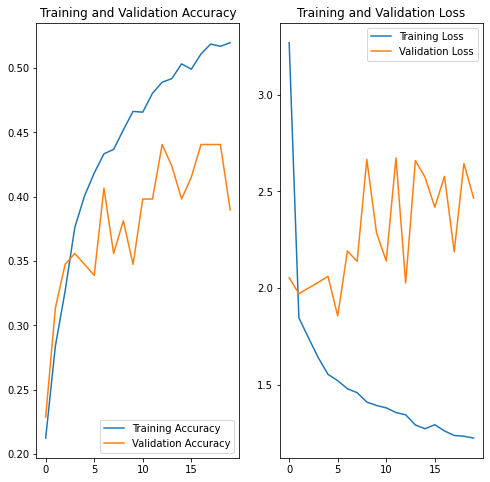

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model2 - With Dropout and Data Augmentation Findings: 


*   There is little improvement in model accuracy , but still there is huge difference between training accuracy and validation accuracy hence there are chances of Overfitting
*   Image Augmentation helped to reduce the overfitting


**### Model 3: Develop the third model by adding Batch Normalization and handling Class Imbalance.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

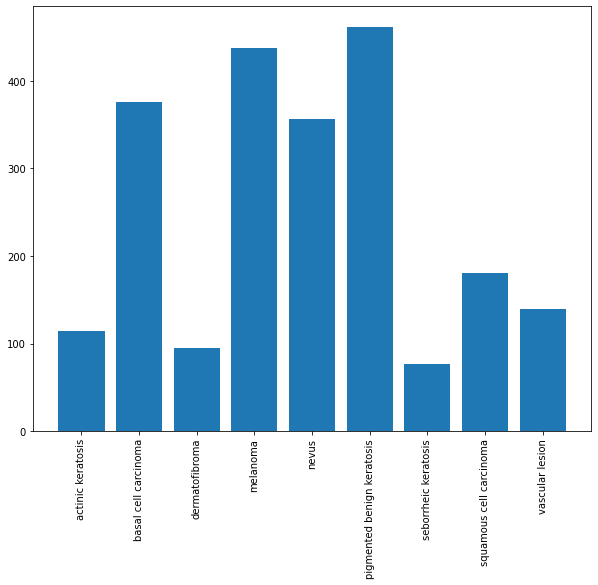

In [85]:
## Plot the Class distribution
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,10))
data = []
y_pos = range(len(class_names))
for cls in class_names:
  cls_data = data_dir_train.glob(cls+'/*.*')
  data.append(len(list(cls_data)))
plt.bar(y_pos, data)
plt.xticks(y_pos, class_names, rotation=90)
plt.subplots_adjust(bottom=0.4, top=0.99)
plt.show()

#### **Findings from Class Distribution:**

*   'seborrheic keratosis' and 'dermatofibroma' has least number of samples
*   'pigmented benign keratosis' and  'melanoma' got most samples than other classes

 


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [80]:
path_to_training_dataset='/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF8363FABD0>: 100%|██████████| 500/500 [00:17<00:00, 28.17 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF8398726D0>: 100%|██████████| 500/500 [00:17<00:00, 28.51 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF836461890>: 100%|██████████| 500/500 [00:18<00:00, 27.77 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF843894CD0>: 100%|██████████| 500/500 [01:24<00:00,  5.89 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FF8438B1850>: 100%|██████████| 500/500 [01:15<00:00,  6.64 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF83991CC10>: 100%|██████████| 500/500 [00:18<00:00, 27.34 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF839A12E90>: 100%|██████████| 500/500 [00:39<00:00, 12.63 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF89802EB90>: 100%|██████████| 500/500 [00:19<00:00, 25.97 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF836461E10>: 100%|██████████| 500/500 [00:18<00:00, 27.19 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [81]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

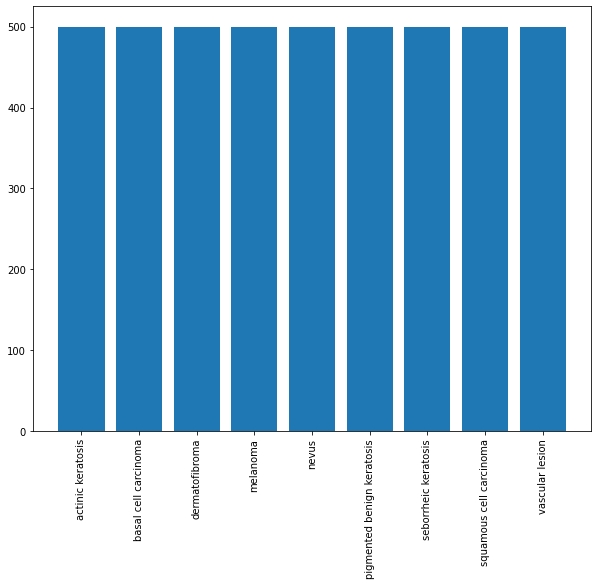

In [87]:
fig=plt.figure(figsize=(10,10))
data = []
y_pos = range(len(class_names))
for cls in class_names:
  cls_data = data_dir_train.glob(cls+'/*/*.*')
  data.append(len(list(cls_data)))
plt.bar(y_pos, data)
plt.xticks(y_pos, class_names, rotation=90)
plt.subplots_adjust(bottom=0.4, top=0.99)
plt.show()

In [93]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000142.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000144.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000139.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000141.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000143.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000168.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000170.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000151.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000303.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000293.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/ISIC_0000299.jpg',

In [90]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/output/melanoma_original_ISIC_0010358.jpg_90916b33-7ac5-456a-b093-48ac941a70d8.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/output/melanoma_original_ISIC_0010140.jpg_5da91b5f-cd8f-430c-99a8-1bc060f97a7b.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/output/melanoma_original_ISIC_0009993.jpg_de5cf08a-3365-4f4c-a2c0-8316d67588a0.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/output/melanoma_original_ISIC_0010194.jpg_8f99f8b3-fccb-4f50-ad46-d9d505a56cb7.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/output/melanoma_original_ISIC_0000393.jpg_548f7155-a5fe-40b9-90a4-d1bdce0d4b95.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/Train/melanoma/output/melanoma_original_ISIC_0009868.jpg_962e9389-2b7b-499b-8bc9-8606d6e6d730.jpg',
 '/content/gdrive/My Drive/Upgrad/cnn_assignment_dataset/T

In [115]:
lesion_list=[]
for cls in class_names:
  ls = [cls for y in glob(os.path.join(data_dir_train, cls, '*.jpg'))]
  lesion_list=lesion_list+ls

  #y=glob(os.path.join(data_dir_train, cls, '*.jpg'))
#  lesion_list.append(os.path.basename(os.path.dirname(os.path.dirname(y))))

# lesion_list = [os.path.dirname(y) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(lesion_list)

2239

In [116]:
lesion_list

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [88]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [102]:
len(lesion_list_new)

4500

In [117]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [118]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [121]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [122]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [123]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [150]:
new_df.head()

,Path,Label
0,/content/gdrive/My Drive/Upgrad/cnn_assignment...,actinic keratosis
1,/content/gdrive/My Drive/Upgrad/cnn_assignment...,actinic keratosis
2,/content/gdrive/My Drive/Upgrad/cnn_assignment...,actinic keratosis
3,/content/gdrive/My Drive/Upgrad/cnn_assignment...,actinic keratosis
4,/content/gdrive/My Drive/Upgrad/cnn_assignment...,actinic keratosis


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [124]:
batch_size = 32
img_height = 180
img_width = 180

#### **Create a training dataset: Approach 1 using ImageDataGenerator with Dataframe as Input** 

In [151]:
datagen = ImageDataGenerator(rescale = 1./255,validation_split=.2)
trainDatagen = datagen.flow_from_dataframe(
    new_df,
    directory=None,
    x_col="Path",
    y_col="Label",
    weight_col=None,
    target_size=(img_width, img_height),
    color_mode="rgb",
    classes=class_names,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    subset='training',
    interpolation="nearest",
    validate_filenames=False
)

Found 5392 non-validated image filenames belonging to 9 classes.


In [152]:
val_Datagen = datagen.flow_from_dataframe(
    new_df,
    directory=None,
    x_col="Path",
    y_col="Label",
    weight_col=None,
    target_size=(img_width, img_height),
    color_mode="rgb",
    classes=class_names,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    subset='validation',
    interpolation="nearest",
    validate_filenames=False
)

Found 1347 non-validated image filenames belonging to 9 classes.


#### **Create a training dataset: Approach 2 using image_dataset_from_directory method with Dataframe as Input** 

In [156]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  # labels='inferred',
  # class_names=class_names,
  seed=123,
  shuffle=True,
  label_mode='int',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [157]:
##validation split
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  # labels='inferred',
  # class_names=class_names,
  seed=123,
  shuffle=True,
  label_mode='int',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [161]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  # labels='inferred',
  # class_names=class_names,
  seed=123,
  shuffle=True,
  label_mode='int',
  # validation_split = 0.2,
  # subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


#### **Create Model3 with Batch Normalization, Dropout and Class Balanced data:** 

In [158]:
#Model 3
def define_cnn_model3():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
 model.add(BatchNormalization())
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(BatchNormalization())
 model.add(MaxPool2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(BatchNormalization())
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(BatchNormalization())
 model.add(MaxPool2D((2, 2)))  
 model.add(Dropout(0.3))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(BatchNormalization())
 model.add(Dropout(0.4))
 model.add(Dense(9, activation='softmax'))
 
 return model

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [162]:
model3=define_cnn_model3()
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #sparse_categorical_crossentropy
model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 180, 180, 32)      9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 90, 90, 64)      

#### **Todo:**  Train your model

In [160]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
    )

Epoch 1/30
169/169 [==============================] - 52s 294ms/step - loss: 2.0950 - accuracy: 0.3297 - val_loss: 2.2128 - val_accuracy: 0.3519
Epoch 2/30
169/169 [==============================] - 49s 285ms/step - loss: 1.3281 - accuracy: 0.5174 - val_loss: 1.3007 - val_accuracy: 0.5494
Epoch 3/30
169/169 [==============================] - 50s 287ms/step - loss: 1.0279 - accuracy: 0.6230 - val_loss: 2.1274 - val_accuracy: 0.4900
Epoch 4/30
169/169 [==============================] - 50s 288ms/step - loss: 0.9326 - accuracy: 0.6662 - val_loss: 1.3547 - val_accuracy: 0.5509
Epoch 5/30
169/169 [==============================] - 50s 286ms/step - loss: 0.7073 - accuracy: 0.7521 - val_loss: 0.9191 - val_accuracy: 0.6897
Epoch 6/30
169/169 [==============================] - 50s 288ms/step - loss: 0.5437 - accuracy: 0.8235 - val_loss: 1.6870 - val_accuracy: 0.7424
Epoch 7/30
169/169 [==============================] - 50s 287ms/step - loss: 0.4526 - accuracy: 0.8419 - val_loss: 2.0970 - val_ac

#### **Todo:**  Visualize the model results

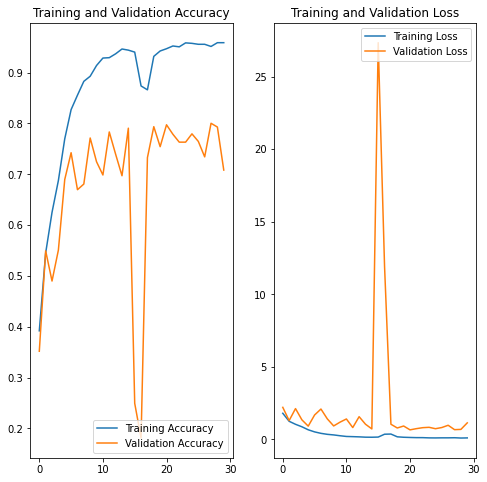

In [163]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Model 3 Results:**

*   Model 3 with Batch Normalization, Dropout and Class Balancing shows great improvement in improving Accuracy and reducing losses
*   Model 3 shows less deviation between Validation and Test data as compared to other two models

class rebalance help?
Yes, by addressing Class Imbalance problem, it helped a long way to improve the model accuracy


**Comparision of Results across Three Models:**




*   Model 1:
    Training Accuracy: 76
    Validation Accuracy: 34

*   Model 2:
    Training Accuracy: 52
    Validation Accuracy: 38
*   Model 3:
    Training Accuracy: 95
    Validation Accuracy: 79










**CONCLUSION:**
MODEL 3 with Balanced Class, Batch Normalization and Dropout performs better than other Models.